In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import sklearn
from sklearn.linear_model import LinearRegression, Ridge, ElasticNet
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from datetime import datetime
import glob

# Reading in data

In [2]:
y = pd.read_excel('data/Returns/Ret_Var.xlsx', index_col=0)

In [3]:
names = []
predictors = []

In [4]:
files = glob.glob("data/HighTurnover/*.xlsx")
for file in files:
    predictors.append(pd.read_excel(file, index_col=0))
    names.append(file.rsplit('/')[-1].rsplit('.')[0])

In [5]:
files = glob.glob("data/MidTurnover/*.xlsx")
for file in files:
    predictors.append(pd.read_excel(file, index_col=0))
    names.append(file.rsplit('/')[-1].rsplit('.')[0])

In [7]:
files = glob.glob("data/LowTurnover/*.xlsx")
for file in files:
    predictors.append(pd.read_excel(file, index_col=0))
    names.append(file.rsplit('/')[-1].rsplit('.')[0])

# Cleaning and preparing

In [9]:
predictors_stacked_bfill = []
for i in range(len(predictors)):
    df_filled = predictors[i].fillna(method='bfill')
    df_filled = df_filled.fillna(0)
    df_filled[pd.isna(y)] = np.NaN
    df_stack = df_filled.stack().dropna()
    df_stack.name = names[i]
    df_stack = df_stack.reset_index()
    predictors_stacked_bfill.append(df_stack)

In [10]:
predictors_stacked_mfill = []
for i in range(len(predictors)):
    df_filled = predictors[i].fillna(predictors[i].median(axis=0))
    df_filled[pd.isna(y)] = np.NaN
    df_stack = df_filled.stack().dropna()
    df_stack.name = names[i]
    df_stack = df_stack.reset_index()
    predictors_stacked_mfill.append(df_stack)

In [14]:
res_bfill.head()

,Permno,level_1,SRR,Ind_Mom,IRR,HFC,IRR_LowVol,Season,Ivol,ROE
0,10001,198601,63.287293,5.0,67.474241,31.829574,40.082645,95.324074,68.651489,98.185625
1,10001,198602,41.019351,8.0,29.991761,72.123043,28.257329,20.418605,40.401146,96.964410
2,10001,198603,31.118314,3.0,37.292743,60.641479,32.786885,6.397775,11.906792,97.028334
3,10001,198604,43.259771,3.0,48.717263,49.358632,48.072384,47.085819,5.141894,74.185807
4,10001,198605,52.233677,2.0,66.861391,29.925651,73.369565,31.218157,1.140156,71.612466


In [21]:
res_bfill = predictors_stacked_bfill[0]
for i in range(1,len(predictors)):
    predictors_stacked_bfill[i].rename(columns={predictors_stacked_bfill[i].columns[0]: "Permno"}, inplace=True)
    res_bfill = pd.merge(res_bfill, predictors_stacked_bfill[i], how="left", left_on=["Permno", "level_1"], right_on=["Permno", "level_1"])
    

In [23]:
res_bfill.shape

(2187349, 26)

In [22]:
res_mfill = predictors_stacked_mfill[0]
for i in range(1,len(predictors)):
    predictors_stacked_mfill[i].rename(columns={predictors_stacked_mfill[i].columns[0]: "Permno"}, inplace=True)
    res_mfill = pd.merge(res_mfill, predictors_stacked_mfill[i], how="left", left_on=["Permno", "level_1"], right_on=["Permno", "level_1"])
    

In [24]:
res_mfill.shape

(2187349, 26)

In [25]:
res_bfill.to_csv("full_predictor_set_bfill.csv")

In [27]:
res_mfill.to_csv("full_predictor_set_mfill.csv")

In [28]:
y_stack = y.stack().dropna()
y_stack.name = "return"
y_stack = y_stack.reset_index()
y_stack.head()

,Permno,level_1,return
0,10001,198601,0.000000
1,10001,198602,0.020408
2,10001,198603,0.025200
3,10001,198604,0.009901
4,10001,198605,-0.009804


In [29]:
y_stack.to_csv("returns.csv")

# Fitting Models

In [40]:
X = pd.read_csv("full_predictor_set_bfill.csv", index_col=0)
y = pd.read_csv("returns.csv", index_col=0)

In [14]:
MSEs_ols, MSEs_ridge, MSEs_elastic = ([], [], [])
R2s_ols, R2s_ridge, R2s_elastic = ([], [], [])
for i in range(198700,201900,100):
    x_train = X[X["level_1"] < i].to_numpy()[:,2:]
    y_train = y[y["level_1"] < i].to_numpy()[:,2:]
    x_test = X[(X["level_1"] >= i) & (X["level_1"] <= i + 100)].to_numpy()[:,2:]
    y_test = y[(y["level_1"] >= i) & (y["level_1"] <= i + 100)].to_numpy()[:,2:]
    
    # OLS
    reg = LinearRegression().fit(x_train, y_train)
    MSEs_ols.append(mean_squared_error(y_test, reg.predict(x_test)))
    R2s_ols.append(r2_score(y_test, reg.predict(x_test)))
    
    # Ridge
    reg = Ridge().fit(x_train, y_train)
    MSEs_ridge.append(mean_squared_error(y_test, reg.predict(x_test)))
    R2s_ridge.append(r2_score(y_test, reg.predict(x_test)))
    
    # Elastic Net
    reg = ElasticNet().fit(x_train, y_train)
    MSEs_elastic.append(mean_squared_error(y_test, reg.predict(x_test)))
    R2s_elastic.append(r2_score(y_test, reg.predict(x_test)))

In [ ]:
np.savetext("MSEs_ols.csv", np.array(MSEs_ols), delimiter=",")
np.savetext("MSEs_ridge.csv", np.array(MSEs_ridge), delimiter=",")
np.savetext("MSEs_elastic.csv", np.array(MSEs_elastic), delimiter=",")
np.savetext("R2s_ols.csv", np.array(R2s_ols), delimiter=",")
np.savetext("R2s_ridge.csv", np.array(R2s_ridge), delimiter=",")
np.savetext("R2s_elastic.csv", np.array(R2s_elastic), delimiter=",")

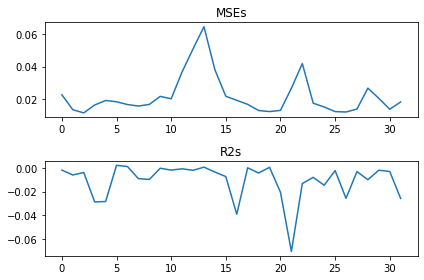

In [15]:
plt.subplot(2,1,1)
plt.plot(MSEs)
plt.title("MSEs")

plt.subplot(2,1,2)
plt.plot(R2s)
plt.title("R2s")

plt.tight_layout()

In [16]:
print(np.mean(MSEs))
print(np.mean(R2s))

0.021920594102669135
-0.010762392924509857


Last MSE and R^2 value with mean filling
0.021918890935935076
-0.010627932052457923